<div id="toc"></div>

In [7]:
%%javascript
$.getScript('https://kmahelona.github.io/ipython_notebook_goodies/ipython_notebook_toc.js')

<IPython.core.display.Javascript object>

last update: 2021/09/16  
created: : 2021/08/17  

In [8]:
cd ~/work

/home/tako/work


\~\/    
/home/tako/  
/Users/chonmac/  

In [9]:
path_pRT = '/home/tako/work/pRT/'
path_VALD3 = '/home/tako/work/VALD3/'
path_fig = '/home/tako/Dropbox/tmpfig/'

In [10]:
%load_ext autoreload
%autoreload 2
from exojax.spec import xsection #in opacity.py
from exojax.spec.hitran import SijT, doppler_sigma, gamma_hitran, gamma_natural
from exojax.spec import moldb, vald3
from exojax.spec import vald3_test_Kurucz_1981 #%\\\\20210917

import numpy as np
%matplotlib notebook
#%matplotlib inline
import matplotlib.pyplot as plt
#import seaborn as sns
#plt.style.use('bmh')

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [11]:
#test to use Unsöld's approximation (instead of wdW gamma from VALD3)
#from exojax.spec import vald3_test210827

# Compute atomic cross section from VALD3 
using exojax, then, convert the data to petitRADTRANS format  

written with reference to "[HITRAN_to_petitRadtran.ipynb](https://gist.github.com/HajimeKawahara/4d3e82621d28b035a6d70e7f7a4635ef)"

## set wavenumber range

In [12]:
1e8/3000, 1e8/6000, 1e8/12000, 1e8/100, 1e8/18000, 1e8/1500

(33333.333333333336,
 16666.666666666668,
 8333.333333333334,
 1000000.0,
 5555.555555555556,
 66666.66666666667)

In [13]:
# Setting wavenumber bins and loading HITRAN database

#nus = np.linspace(8333., 10000., 200000, dtype=np.float64) #(cm-1) with a resolution of 0.01 (cm-1)  ->wlen_4204004.dat
nus = np.arange(1e8/13000, 1e8/11000, 0.01, dtype=np.float64)
adbFe = moldb.AdbVald(path_VALD3+'HiroyukiIshikawa.4204596.gz', nus)#, crit=1.e-100)
#HiroyukiIshikawa.4204004.gz: 10000–12000Å, Fe I
#HiroyukiIshikawa.4204095.gz: 6000–12000Å, Fe I
#HiroyukiIshikawa.4204595.gz: 3000–12000Å, Fe I
#HiroyukiIshikawa.4204596.gz: 100–18000Å, Fe I


#%\\\\20210917
#/home/tako/miniconda3/lib/python3.9/site-packages/IPython/core/interactiveshell.py:3437: DtypeWarning: Columns (1,2) have mixed types.Specify dtype option on import or set low_memory=False.exec(code_obj, self.user_global_ns, self.user_ns)  

Reading VALD file


/home/tako/miniconda3/lib/python3.9/site-packages/IPython/core/interactiveshell.py:3437: DtypeWarning: Columns (1,2) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


In [14]:
1e8/adbFe.dev_nu_lines

DeviceArray([13001.237 , 13001.237 , 13001.237 , ..., 10999.6875,
             10999.641 , 10998.874 ], dtype=float32)

---

# test↓
#tmp

In [15]:
help(vald3_test_Kurucz_1981.gamma_vald3_Kurucz1981)

Help on function gamma_vald3_Kurucz1981 in module exojax.spec.vald3_test_Kurucz_1981:

gamma_vald3_Kurucz1981(T, PH, PHH, PHe, nu_lines, elower, ionE, gamRad, vdWdamp, enh_damp=1.0)
    testing210917 18:51
      gamma factor by a pressure broadening
      based on Gray+2005(2005oasp.book.....G)
    
    Args(inputs):
      T: temperature (K) (array)
      PH: hydrogen pressure (bar) (array)  #1 bar = 1e6 dyn/cm2 (array)
      PHH: H2 molecule pressure (bar) (array)
      PHe: helium pressure (bar) (array)
      nu_lines:  transition waveNUMBER in [cm-1] (NOT frequency in [s-1])
      elower: excitation potential (lower level) [cm-1]
      ionE: ionization potential [eV]
      vdWdamp:  van der Waals damping parameters
      gamRad: gamma(HWHM of Lorentzian) of radiation damping
      enh_damp: empirical "enhancement factor" for classical Unsoeld's damping constant
    
    Args(calculated):
      chi_lam (=h*nu=1.2398e4/wvl[AA]): energy of a photon in the line
      C6: interaction con

In [33]:
from exojax.spec import vald3_test_Kurucz_1981 #%\\\\20210917

In [27]:
adbFe.atomicmass, adbFe.ionE

(DeviceArray([55.847, 55.847, 55.847, ..., 55.847, 55.847, 55.847], dtype=float32),
 DeviceArray([7.87, 7.87, 7.87, ..., 7.87, 7.87, 7.87], dtype=float32))

In [24]:
nus = np.arange(8333., 33333., 0.01, dtype=np.float64)
print(nus.shape)
outdir=path_pRT+"input_data/opacities/lines/line_by_line/Fe_exojax/" #CO_exojax/"
np.array(1.0/nus[::-1], dtype=np.float64).tofile(outdir+"wlen_4204595.dat") #wavelength

(2500000,)


In [174]:
import pandas as pd
gnve = pd.read_csv(path_VALD3+'HiroyukiIshikawa.4204595.gz', sep=",", skiprows=1, \
    names=("species","wav_lines","loggf","elowereV","jlower","euppereV", "jupper", "landelower", "landeupper", "landemean", "rad_damping","stark_damping","waals_damping")\
                     )
gnve = gnve[gnve.species.str.startswith("'")] #Remove rows not starting with "'"
gnve = gnve[gnve.species.str.startswith("' ").map({False: True, True: False})] #Remove rows of Reference
gnve = gnve[gnve.species.str.startswith("'_").map({False: True, True: False})] #Remove rows of Reference

gnve = gnve[ gnve.species.str.len()<7 ] #Remove long name (molecules e.g., TiO)
gnve = gnve[gnve.species.str[1:3].str.isupper().map({False: True, True: False})] #Remove names starting with successive uppercase letters (molecules e.g., CO, OH, CN)
#gnve = gnve[gnve.species.str.startswith("'CO").map({False: True, True: False})]
gnve = gnve.reset_index(drop=True)

gnve = gnve.astype({'wav_lines': 'float64', 'loggf': 'float64', 'elowereV': 'float64', 'jlower': 'float64', 'euppereV': 'float64'})

test↑

---

## Compute cross section and save in pRT format

In [17]:
#Define the weight of species of interest (u), temperature (K), and pressure (bar). 
#    Assuming the 100 % atmosphere of the species of interest, i.e. the partial pressure = pressure.
Amol=np.float64( adbFe.atomicmass[0] ) #atomic mass [u]   
Tarr=np.logspace(2, 3.5, 10)#test(2, 3.5, 2)
Parr=np.logspace(-10,2,13)#test(-1, 2, 2)
nu0=adbFe.nu_lines

In [18]:
outdir=path_pRT+"input_data/opacities/lines/line_by_line/Fe_exojax/" #CO_exojax/"
np.array(1.0/nus[::-1], dtype=np.float64).tofile(outdir+"wlen.dat") #wavelength
PHstr = '_4204596' #'solar_Uns'
out_suffix = '_PH'+PHstr #_crit120' #''
out_suffix = '_11to13_testgamRad' #'_test_Kurucz1981'
out_suffix = '_tmp'

f=open(outdir+"PTpaths.ls","w")
for Tfix in Tarr[-1:]:  #test [-1:]
    qt = np.ones_like(adbFe.A) * np.float32(adbFe.qr_interp("Fe 1", Tfix))
    #↑Unlike the case of HITRAN (using Qr_HAPI), we ignored the isotopes.  #tako 
    sigmaD=doppler_sigma(adbFe.nu_lines, Tfix, Amol)
    for Pfix in Parr[9:10]:  #test [9:10]
        #Ppart=Pfix #partial pressure: Here we assume a 100% pure atmosphere of the species of interest. 
        #0.01*↓#%\\\\20210917
        PH=Pfix* 0.0 #0.05  #float(PHstr) #*0.3    #Hydrogen pressure: affect gammaL largely  #%\\\\20210818
        PHH=Pfix* 0.84 #0.1  #PH*2 #*0.6
        PHe=Pfix* 0.16 #0.005  #PH*0.1 #*0.08
        #"solar-frac":(xH,xHe,xH2)=(0.0,0.16,0.84) by Kawashima-san
        #takofrac: 0.05,0.005,0.1

        Sij = SijT(Tfix, adbFe.logsij0, adbFe.nu_lines, adbFe.elower, qt)
        #gammaL = vald3_test210827.gamma_vald3(  #_Unsöld
        #gammaL = vald3_test_Kurucz_1981.gamma_vald3_Kurucz1981(
        gammaL = vald3.gamma_vald3(Tfix, PH, PHH, PHe, \
                        adbFe.dev_nu_lines, adbFe.elower, adbFe.ionE, \
                        adbFe.gamRad, adbFe.vdWdamp, 1.0) \
                        + vald3.gamma_natural(adbFe.A)   #/2#ghalf \  %\\\\20210917
        # thermal doppler sigma
        xsv = xsection(nus, nu0, sigmaD, gammaL, Sij, memory_size=30) 
        Pval = "{:.6f}".format(Pfix)
        P = str(Pval)+"bar"
        out = "sigma_99_"+str(Tfix)+".K_"+P+out_suffix+".dat"
        f.write(str(Pval)+" "+str(Tfix)+" "+out+"\n")    
        op = np.array(xsv[::-1],dtype=np.float64)/(Amol*1.66053892e-24)
        op.tofile(outdir+out)
f.close()

#\here\

/home/tako/miniconda3/lib/python3.9/site-packages/exojax-0.5.5-py3.9.egg/exojax/spec/vald3.py:102: RuntimeWarning: invalid value encountered in double_scalars
  gam6H = 10**vdWdamp * (T/10000.)**Texp * PH*1e6 /(kcgs*T)
/home/tako/miniconda3/lib/python3.9/site-packages/exojax-0.5.5-py3.9.egg/exojax/spec/vald3.py:104: RuntimeWarning: invalid value encountered in double_scalars
  gam6HH = 10**vdWdamp * (T/10000.)**Texp * PHH*1e6*0.85 /(kcgs*T)
100%|██████████| 105/105 [00:01<00:00, 83.37it/s] 


In [169]:
#check
print(nus.shape, nu0.shape, sigmaD.shape, gammaL.shape, Sij.shape)

np.where(np.isnan(gammaL)), \
len(np.where(np.isnan(gammaL))[0]), \
np.where(np.isnan(adbFe.dev_nu_lines)), \
np.where(np.isnan(adbFe.elower)), \
np.where(np.isnan(adbFe.ionE)), \
np.where(np.isnan(adbFe.gamRad)), \
np.where(np.isnan(adbFe.vdWdamp))

(139861,) (5849,) (5849,) (5849,) (5849,)


((array([], dtype=int64),),
 0,
 (array([], dtype=int64),),
 (array([], dtype=int64),),
 (array([], dtype=int64),),
 (array([], dtype=int64),),
 (array([], dtype=int64),))

<IPython.core.display.Javascript object>


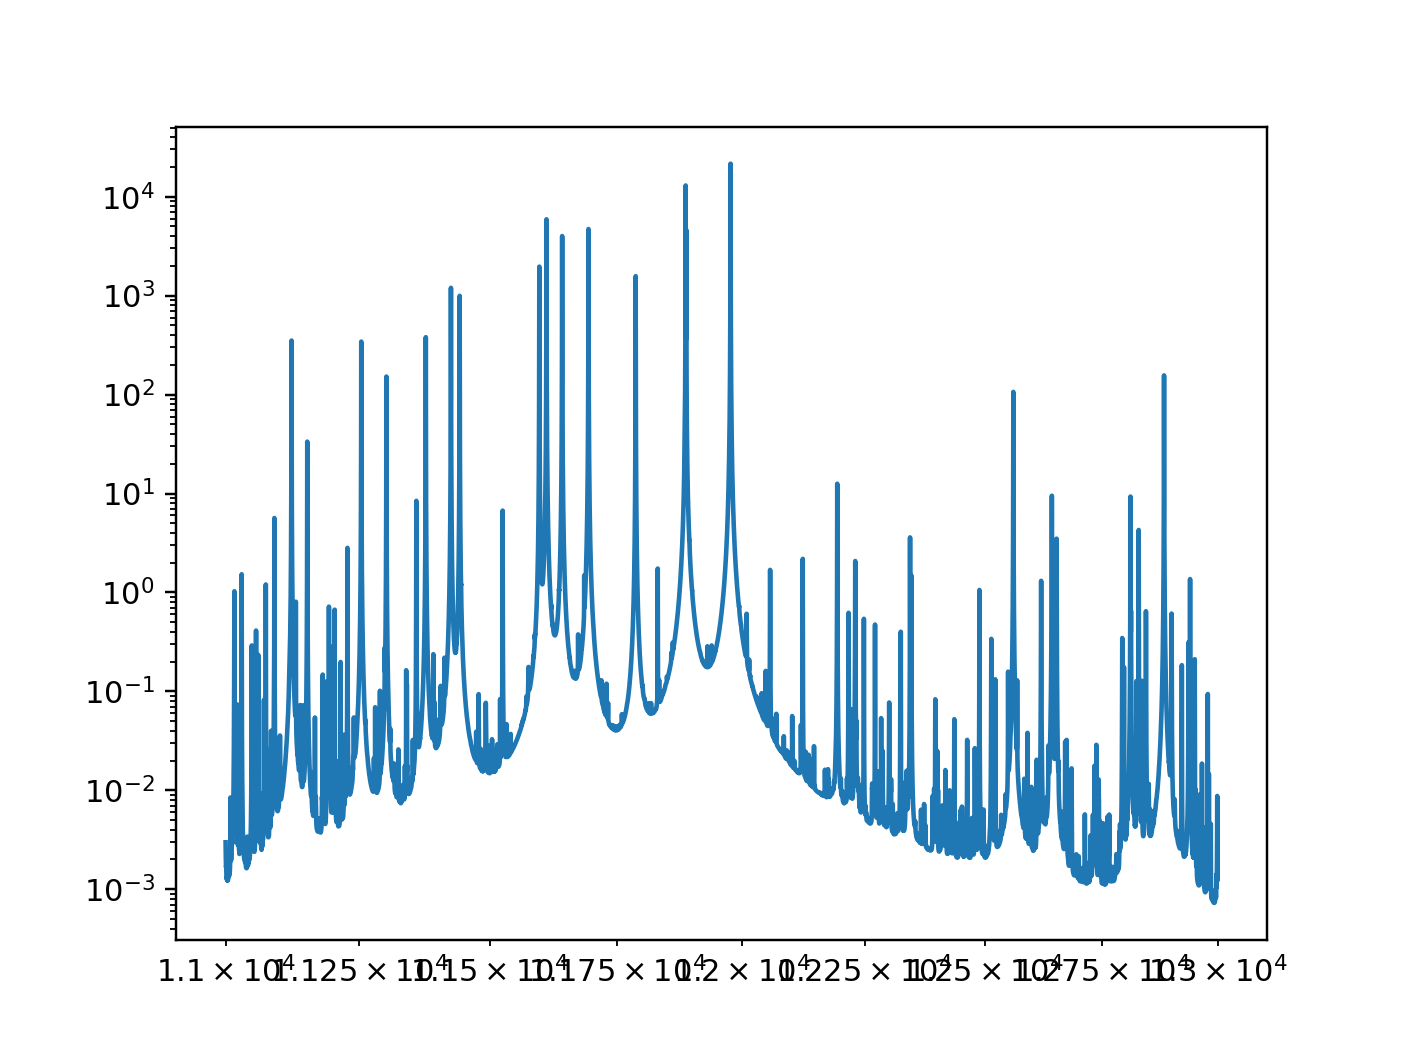

3162.2776601683795 
 0.1


In [170]:
#check for Fe I

plt.figure()
plt.plot(1.e8/nus[::-1],  op)
plt.yscale("log")
plt.xscale("log")
plt.show()
print(Tfix, '\n', Pfix)

# Compare with petitRADTRANS for METAL

written with reference to "[petitRadtran high-resolution IO.ipynb](https://gist.github.com/HajimeKawahara/69f633cfc29dffab913997a4b0e6a4c0)"

In [171]:
xrg = (11000, 11250) #(10000, 12000) 
yrg = (1e-27, 1e-17)
out_suffix = out_suffix #'_PH0.05' #'_crit120' #''
print(out_suffix)

_11to13_testgamRad


### Case of exojax

In [172]:
petit_exojaxdir=path_pRT+"input_data/opacities/lines/line_by_line/Fe_exojax/"

with open(petit_exojaxdir+"wlen.dat", 'rb') as w:
    contentw = np.fromfile(w, dtype=np.float64)
    
fn_exo="sigma_99_3162.2776601683795.K_0.100000bar"+out_suffix+".dat"
with open(petit_exojaxdir+fn_exo, 'rb') as f:
    contentf = np.fromfile(f, dtype=np.float64)
    
print(fn_exo)

sigma_99_3162.2776601683795.K_0.100000bar_11to13_testgamRad.dat


<IPython.core.display.Javascript object>


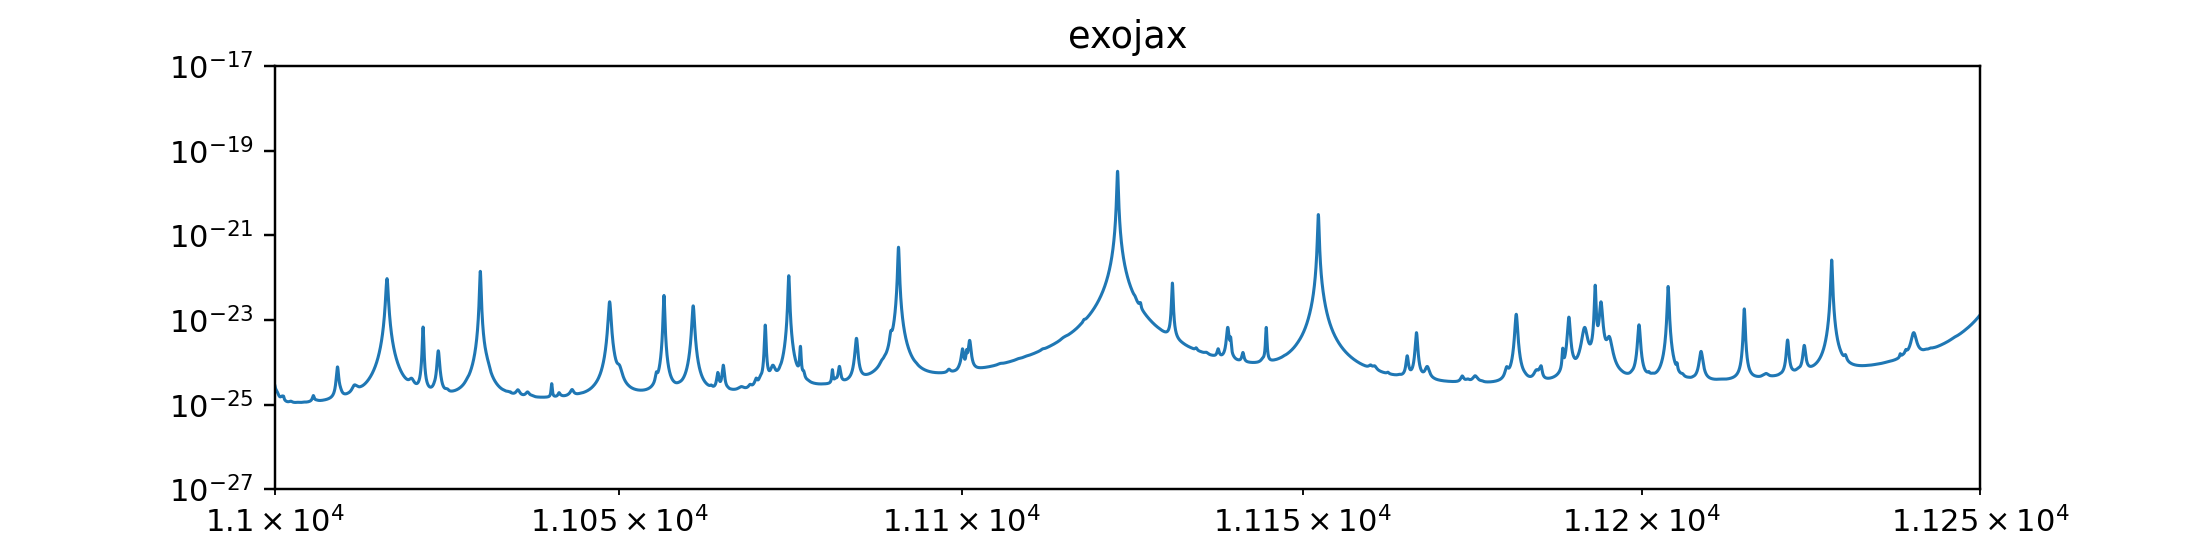

In [173]:
species_mass=55.847
xs=np.array(contentf)*species_mass*1.66053892e-24
wav=np.array(contentw,dtype=np.float64) #cm

fig=plt.figure(figsize=(10,2.5))
plt.plot(wav*1.e8, xs, lw=1) #, label='(xH,xHe,xH2)=(0.05,0.005,0.1),')
#plt.plot(wav*1.e8, xs_sol, ':', lw=1, label='(xH,xHe,xH2)=(0.0,0.16,0.84)')
plt.xlim(xrg)
plt.ylim(yrg)

plt.yscale("log")
plt.xscale("log") 
plt.title('exojax')
plt.xlabel("wavelength ($\AA$)")
#plt.legend()

#plt.savefig(path_fig+'comp_exojax_Fe'+out_suffix+'.pdf') #comp_exojax_Fe_210823_gamma'+out_suffix+'.pdf
plt.show()

<IPython.core.display.Javascript object>


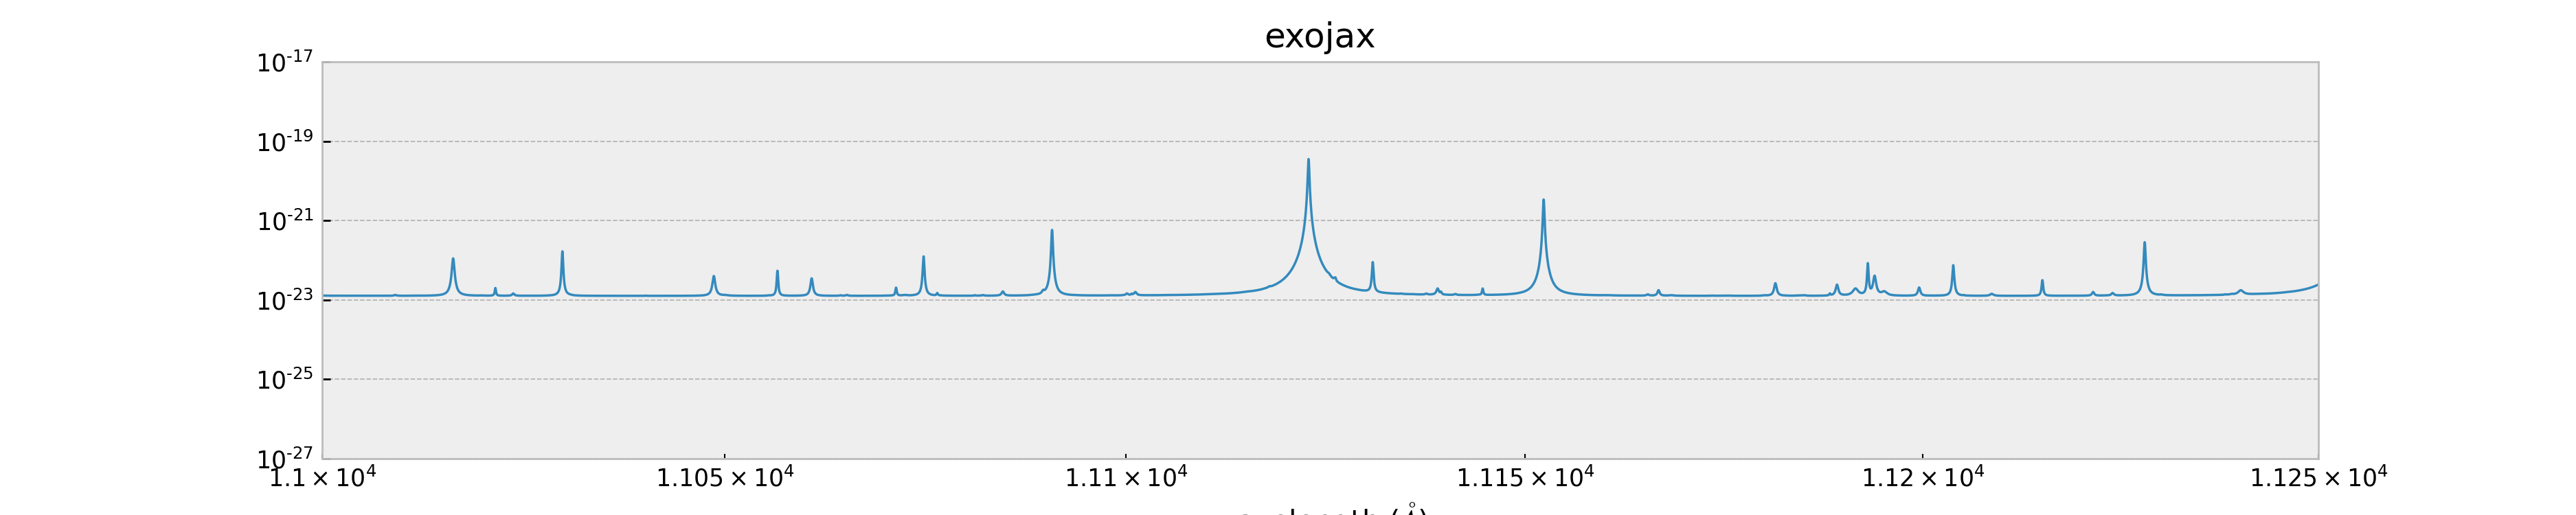

In [15]:
#BU

species_mass=55.847
xs=np.array(contentf)*species_mass*1.66053892e-24
wav=np.array(contentw,dtype=np.float64) #cm

fig=plt.figure(figsize=(15,3))
plt.plot(wav*1.e8, xs, lw=1) #, label='(xH,xHe,xH2)=(0.05,0.005,0.1),')
#plt.plot(wav*1.e8, xs_sol, ':', lw=1, label='(xH,xHe,xH2)=(0.0,0.16,0.84)')
plt.xlim(xrg)
plt.ylim(yrg)

plt.yscale("log")
plt.xscale("log") 
plt.title('exojax')
plt.xlabel("wavelength ($\AA$)")
#plt.legend()

#plt.savefig(path_fig+'comp_exojax_Fe_210823_gamma'+out_suffix+'.pdf')
plt.show()

<IPython.core.display.Javascript object>


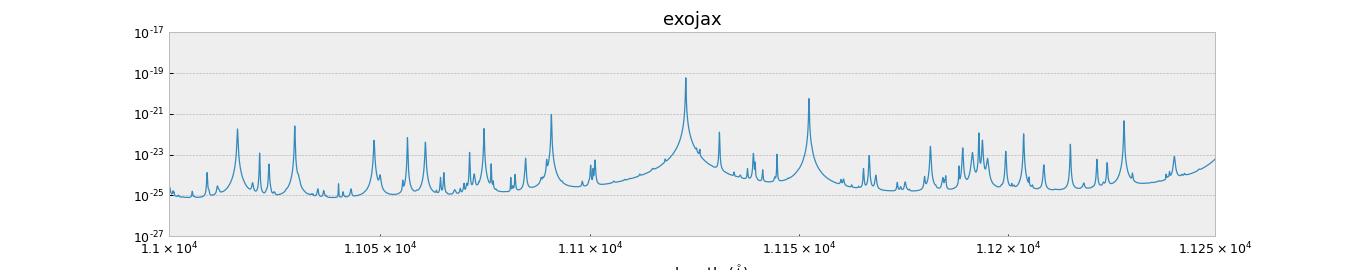

In [38]:
#BU


species_mass=55.847
xs=np.array(contentf)*species_mass*1.66053892e-24
wav=np.array(contentw,dtype=np.float64) #cm

fig=plt.figure(figsize=(15,3))
plt.plot(wav*1.e8, xs, lw=1) #, label='(xH,xHe,xH2)=(0.05,0.005,0.1),')
#plt.plot(wav*1.e8, xs_sol, ':', lw=1, label='(xH,xHe,xH2)=(0.0,0.16,0.84)')
plt.xlim(xrg)
plt.ylim(yrg)

plt.yscale("log")
plt.xscale("log") 
plt.title('exojax')
plt.xlabel("wavelength ($\AA$)")
#plt.legend()

#plt.savefig(path_fig+'comp_exojax_Fe_210823_gamma'+out_suffix+'.pdf')
plt.show()

### Case of petitRADTRANS

In [39]:
petitdir=path_pRT+"input_data/opacities/lines/line_by_line/Fe/"

with open (petitdir+"wlen.dat") as w:
    contentw_p = np.fromfile(w, dtype=np.float64)
    
fn_pet="sigma_99_3250.K_0.100000bar.dat"
with open(petitdir+fn_pet, 'rb') as f:
    contentf_p = np.fromfile(f, dtype=np.float64)

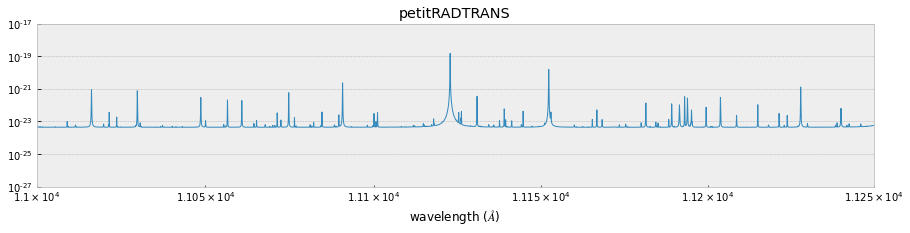

In [28]:
species_mass=55.847
xs_p=np.array(contentf_p)*species_mass*1.66053892e-24
wav_p=np.array(contentw_p,dtype=np.float64) #cm

fig=plt.figure(figsize=(15,3))
plt.plot(wav_p*1.e8, xs_p, lw=1)
plt.xlim(xrg)
plt.ylim(yrg)

plt.yscale("log")
plt.xscale("log") 
plt.title('petitRADTRANS')
plt.xlabel("wavelength ($\AA$)")

plt.show()
#plt.savefig(path_fig+'comp_petitR_Fe_210823.pdf')

### Difference

In [179]:
import scipy as sp
from matplotlib import gridspec

%matplotlib notebook
#%matplotlib inline

In [131]:
len( np.where((wav*1.e8>xrg[0]) & (wav*1.e8<xrg[1]))[0] ), len( np.where((wav_p*1.e8>xrg[0]) & (wav_p*1.e8<xrg[1]))[0] )

(24238, 22472)

In [193]:
wav_p_excerpt = wav_p[np.where((wav_p*1.e8>xrg[0]-1) & (wav_p*1.e8<xrg[1]+1))[0]]
xs_p_excerpt = xs_p[np.where((wav_p*1.e8>xrg[0]-1) & (wav_p*1.e8<xrg[1]+1))[0]]
wav_excerpt = wav[np.where((wav*1.e8>xrg[0]) & (wav*1.e8<xrg[1]))[0]]
xs_excerpt = xs[np.where((wav*1.e8>xrg[0]) & (wav*1.e8<xrg[1]))[0]]
xs_p_interp = sp.interpolate.interp1d(wav_p_excerpt, xs_p_excerpt, kind="quadratic")(wav_excerpt)

<IPython.core.display.Javascript object>


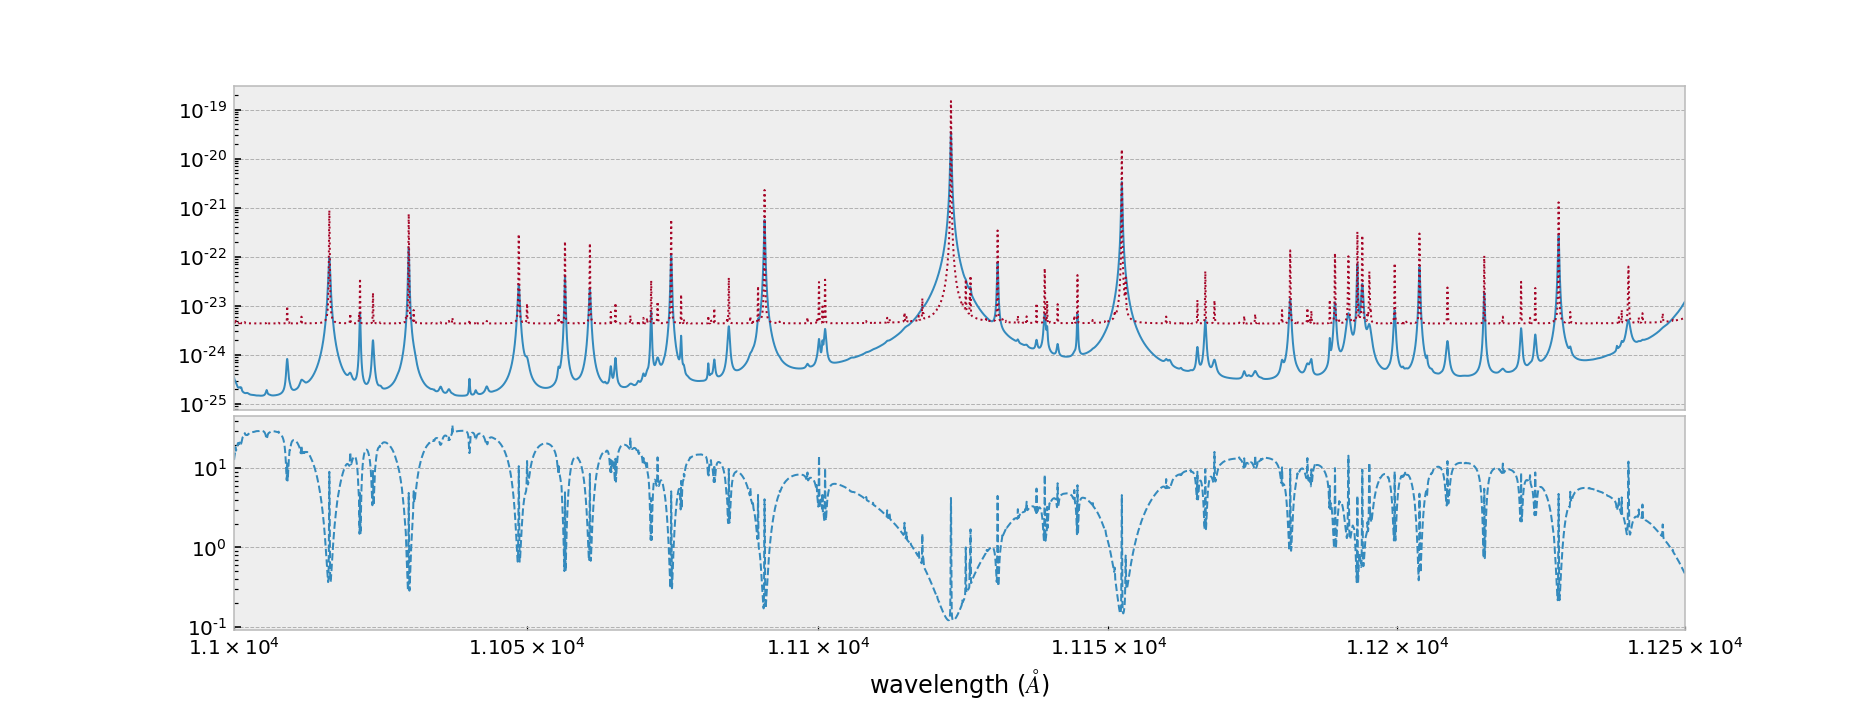

In [133]:
fig=plt.figure(figsize=(13,5)) #15, 5
gs=gridspec.GridSpec(5,1)
ax1=plt.subplot(gs[0:3])
ax2=plt.subplot(gs[3:], sharex=ax1)

ax1.plot(wav_excerpt*1.e8, xs_excerpt, lw=1)
ax1.plot(wav_excerpt*1.e8, xs_p_interp, ':', lw=1)
ax2.plot(wav_excerpt*1.e8, xs_p_interp/xs_excerpt, '--', lw=1)

ax1.set_xlim(xrg)
#ax1.set_ylim(yrg)

ax1.set_xscale("log")
ax1.set_yscale("log")
ax2.set_yscale("log")
ax1.axes.xaxis.set_visible(False)
ax2.set_xlabel("wavelength ($\AA$)")

plt.subplots_adjust(hspace=.05)
plt.show()
#plt.savefig(path_fig+'comp_diff_Fe'+out_suffix+'.pdf')

### Comparison with opacity calculated by Kawashima-san
- Pressure broadeningはKurucz & Avrett (1981)の式  
- VMRを変えて2パターン："ishikawa-frac"=(xH,xHe,xH2)=(0.05,0.005,0.1), "solar-frac"=(xH,xHe,xH2)=(0.0,0.16,0.84)（この温度・圧力での太陽組成の場合の化学平衡組成ではありませんが、低温の時には大体この値なのでsolarと付けています）
- Feの原子量は55.845、イオン化エネルギーは7.9024 [eV]
- 分配関数は、Irwin (1981)の多項式展開
- Kuruczのline list（リンク先のgf2600.all）を使ったのですが、全transition45,118本中、（バグなのか）上と下の準位が逆転しているものが半分以上の24,696本もありました。VALDの方や石川君が計算する時にどうしたか知らないのですが、ファイル名に"excluded"と付いているものはそれらの遷移を単純に除外し、"inverted"と付いているものはエネルギー準位の高い方が上だと思って逆転させて使用しました。

In [64]:
ko_ish_wo_VIS = np.loadtxt('Fe_0.1bar-3250K_inverted_ishikawa-frac_wo-optical-lines.dat', comments='#')
ko_sol_inverted = np.loadtxt('Fe_0.1bar-3250K_inverted_solar-frac.dat', comments='#')
ko_sol_excluded = np.loadtxt('Fe_0.1bar-3250K_excluded_solar-frac.dat', comments='#')
ko_ish_inverted = np.loadtxt('Fe_0.1bar-3250K_inverted_ishikawa-frac.dat', comments='#')
ko_ish_excluded = np.loadtxt('Fe_0.1bar-3250K_excluded_ishikawa-frac.dat', comments='#')

In [65]:
# Convert wavelength [Angstrom] to vacuum (from air)
'''
def air_to_vac(wavelength):
    """[specutils](https://github.com/astropy/specutils/blob/0933a8e271ab1e333337087433cb683da8ab5a54/specutils/utils/wcs_utils.py#L366  )
    Implements the air to vacuum wavelength conversion described in eqn 65 of
    Griesen 2006
    """
    wlum = wavelength.to(u.um).value
    return (1+1e-6*(287.6155+1.62887/wlum**2+0.01360/wlum**4)) * wavelength
from astropy import units as u
wav_yk = air_to_vac(ko_sol_inverted[:, 0] * 1e4 * u.um).value
'''
def wavelength_air_to_vacuum(WL_air): 
    """[VALD Documentation](https://www.astro.uu.se/valdwiki/Air-to-vacuum%20conversion)
    """
    n_pre = 1.0 + 0.0000834254 + (0.02406147 / (130.0 - (WL_air*1.000274*0.0001)**2.0)) + (0.00015998 / (38.9 - (WL_air*1.000274*0.0001)**2.0))
    n = 1.0 + 0.0000834254 + (0.02406147 / (130.0 - (WL_air*n_pre*0.0001)**2.0)) + (0.00015998 / (38.9 - (WL_air*n_pre*0.0001)**2.0))
    return(WL_air * n)
wav_yk = np.array(list(map(wavelength_air_to_vacuum, ko_sol_inverted[:, 0] * 1e4)))

In [147]:
wavelength_air_to_vacuum(10002.328)
11983.0052/wavelength_air_to_vacuum(11983.0052)*11983.0052

11979.71254805769

#### vs petitRADTRANS

<IPython.core.display.Javascript object>


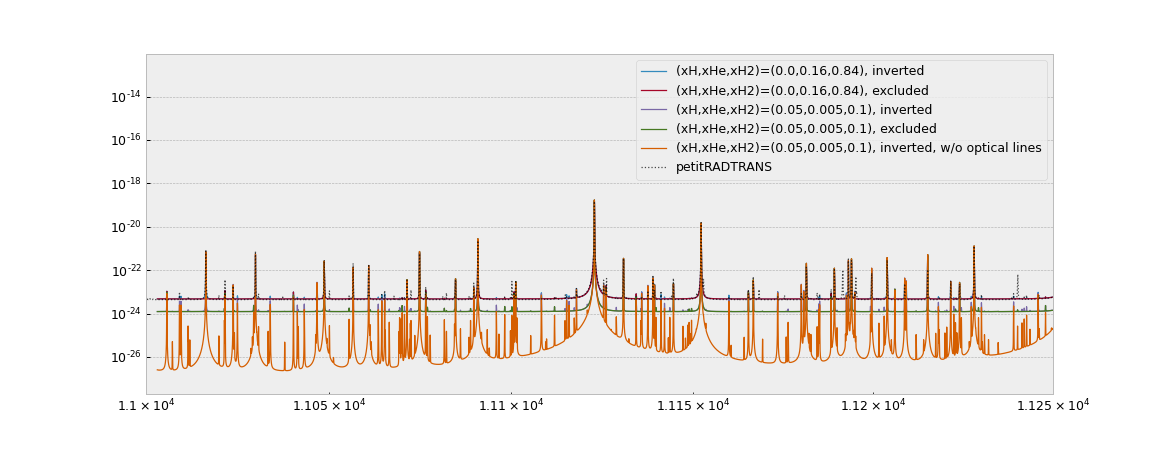

In [96]:
fig=plt.figure(figsize=(13,5)) #15, 5

plt.plot(wav_yk, ko_sol_inverted[:,1], lw=1, label='(xH,xHe,xH2)=(0.0,0.16,0.84), inverted')
plt.plot(wav_yk, ko_sol_excluded[:,1], lw=1, label='(xH,xHe,xH2)=(0.0,0.16,0.84), excluded')
plt.plot(wav_yk, ko_ish_inverted[:,1], lw=1, label='(xH,xHe,xH2)=(0.05,0.005,0.1), inverted')
plt.plot(wav_yk, ko_ish_excluded[:,1], lw=1, label='(xH,xHe,xH2)=(0.05,0.005,0.1), excluded')

plt.plot(wav_yk, ko_ish_wo_VIS[:,1], lw=1, label='(xH,xHe,xH2)=(0.05,0.005,0.1), inverted, w/o optical lines')
plt.plot(wav_p*1.e8, xs_p, 'k', linestyle=':', lw=1, alpha=0.7, label='petitRADTRANS')

plt.xlim(11000, 11250)
plt.yscale("log")
plt.xscale("log") 
plt.legend()
#plt.savefig(path_fig+'comp_diff_Fe'+'_yk_and_pRT'+'.pdf') #out_suffix
plt.show()

#### vs exojax
This is the important figure for the sanity check...

In [66]:
xrg = (11000, 11250)

In [67]:
petit_exojaxdir=path_pRT+"input_data/opacities/lines/line_by_line/Fe_exojax/"

species_mass=55.847

with open(petit_exojaxdir+"wlen.dat", 'rb') as w:
    contentw = np.fromfile(w, dtype=np.float64)
wav=np.array(contentw,dtype=np.float64) #cm
#index_excerpt = np.where((wav*1.e8>xrg[0]) & (wav*1.e8<xrg[1]))[0]
#wav_excerpt = wav[index_excerpt]

with open(petit_exojaxdir+"wlen_4204004.dat", 'rb') as w:
    contentw = np.fromfile(w, dtype=np.float64)
wav_4204004=np.array(contentw,dtype=np.float64) #cm
index_4204004ex = np.where((wav_4204004*1.e8>xrg[0]) & (wav_4204004*1.e8<xrg[1]))[0]
wav_4204004ex = wav_4204004[index_4204004ex]

with open(petit_exojaxdir+"wlen_4204595.dat", 'rb') as w:
    contentw = np.fromfile(w, dtype=np.float64)
wav_4204595=np.array(contentw,dtype=np.float64) #cm
index_4204595ex = np.where((wav_4204595*1.e8>xrg[0]) & (wav_4204595*1.e8<xrg[1]))[0]
wav_4204595ex = wav_4204595[index_4204595ex]

with open(petit_exojaxdir+"wlen_4204596.dat", 'rb') as w:
    contentw = np.fromfile(w, dtype=np.float64)
wav_4204596=np.array(contentw,dtype=np.float64) #cm
index_4204596ex = np.where((wav_4204596*1.e8>xrg[0]) & (wav_4204596*1.e8<xrg[1]))[0]
wav_4204596ex = wav_4204596[index_4204596ex]

'''
fn_exo_sol="sigma_99_3162.2776601683795.K_0.100000bar_PHsolar.dat"
with open(petit_exojaxdir+fn_exo_sol, 'rb') as f:
    contentf = np.fromfile(f, dtype=np.float64)
xs_sol=np.array(contentf)*species_mass*1.66053892e-24
xs_sol_excerpt = xs_sol[index_excerpt]

fn_exo_ish="sigma_99_3162.2776601683795.K_0.100000bar_PH0.05.dat"
with open(petit_exojaxdir+fn_exo_ish, 'rb') as f:
    contentf = np.fromfile(f, dtype=np.float64)
xs_ish=np.array(contentf)*species_mass*1.66053892e-24
xs_ish_excerpt = xs_ish[index_excerpt]
#'''

fn_exo_test="sigma_99_3162.2776601683795.K_0.100000bar_PHsolar.dat" #3000–12000Å
with open(petit_exojaxdir+fn_exo_test, 'rb') as f:
    contentf = np.fromfile(f, dtype=np.float64)
xs_wopt10000=np.array(contentf)*species_mass*1.66053892e-24 #with optical wavelength
xs_wopt10000ex = xs_wopt10000[index_4204004ex]

fn_exo_test="sigma_99_3162.2776601683795.K_0.100000bar_PH_4204595.dat" #3000–12000Å
with open(petit_exojaxdir+fn_exo_test, 'rb') as f:
    contentf = np.fromfile(f, dtype=np.float64)
xs_wopt3000=np.array(contentf)*species_mass*1.66053892e-24 #with optical wavelength
xs_wopt3000ex = xs_wopt3000[index_4204595ex]

'''
fn_exo_test="sigma_99_3162.2776601683795.K_0.100000bar_PH_4204595_ghalftmp.dat" #Half-gammaL  
with open(petit_exojaxdir+fn_exo_test, 'rb') as f:
    contentf = np.fromfile(f, dtype=np.float64)
xs_ghalf=np.array(contentf)*species_mass*1.66053892e-24 #make gammaL half
#xs_ghalf_excerpt = xs_ghalf[index_excerpt]

fn_exo_test="sigma_99_3162.2776601683795.K_0.100000bar_PH_4204595_opt.dat" #only optical?
with open(petit_exojaxdir+fn_exo_test, 'rb') as f:
    contentf = np.fromfile(f, dtype=np.float64)
xs_opt=np.array(contentf)*species_mass*1.66053892e-24 #make gammaL half
#'''

fn_exo_test="sigma_99_3162.2776601683795.K_0.100000bar_PH_4204596.dat" #100–12000Å
with open(petit_exojaxdir+fn_exo_test, 'rb') as f:
    contentf = np.fromfile(f, dtype=np.float64)
xs_wopt=np.array(contentf)*species_mass*1.66053892e-24 #with optical wavelength
xs_woptex = xs_wopt[index_4204596ex]



fn_exo_test="sigma_99_3162.2776601683795.K_0.100000bar_11to13_takofrac.dat" #100–12000Å
with open(petit_exojaxdir+fn_exo_test, 'rb') as f:
    contentf = np.fromfile(f, dtype=np.float64)
xs_takofrac=np.array(contentf)*species_mass*1.66053892e-24 #with optical wavelength


In [68]:
xrg = (11115, 11130)

<IPython.core.display.Javascript object>


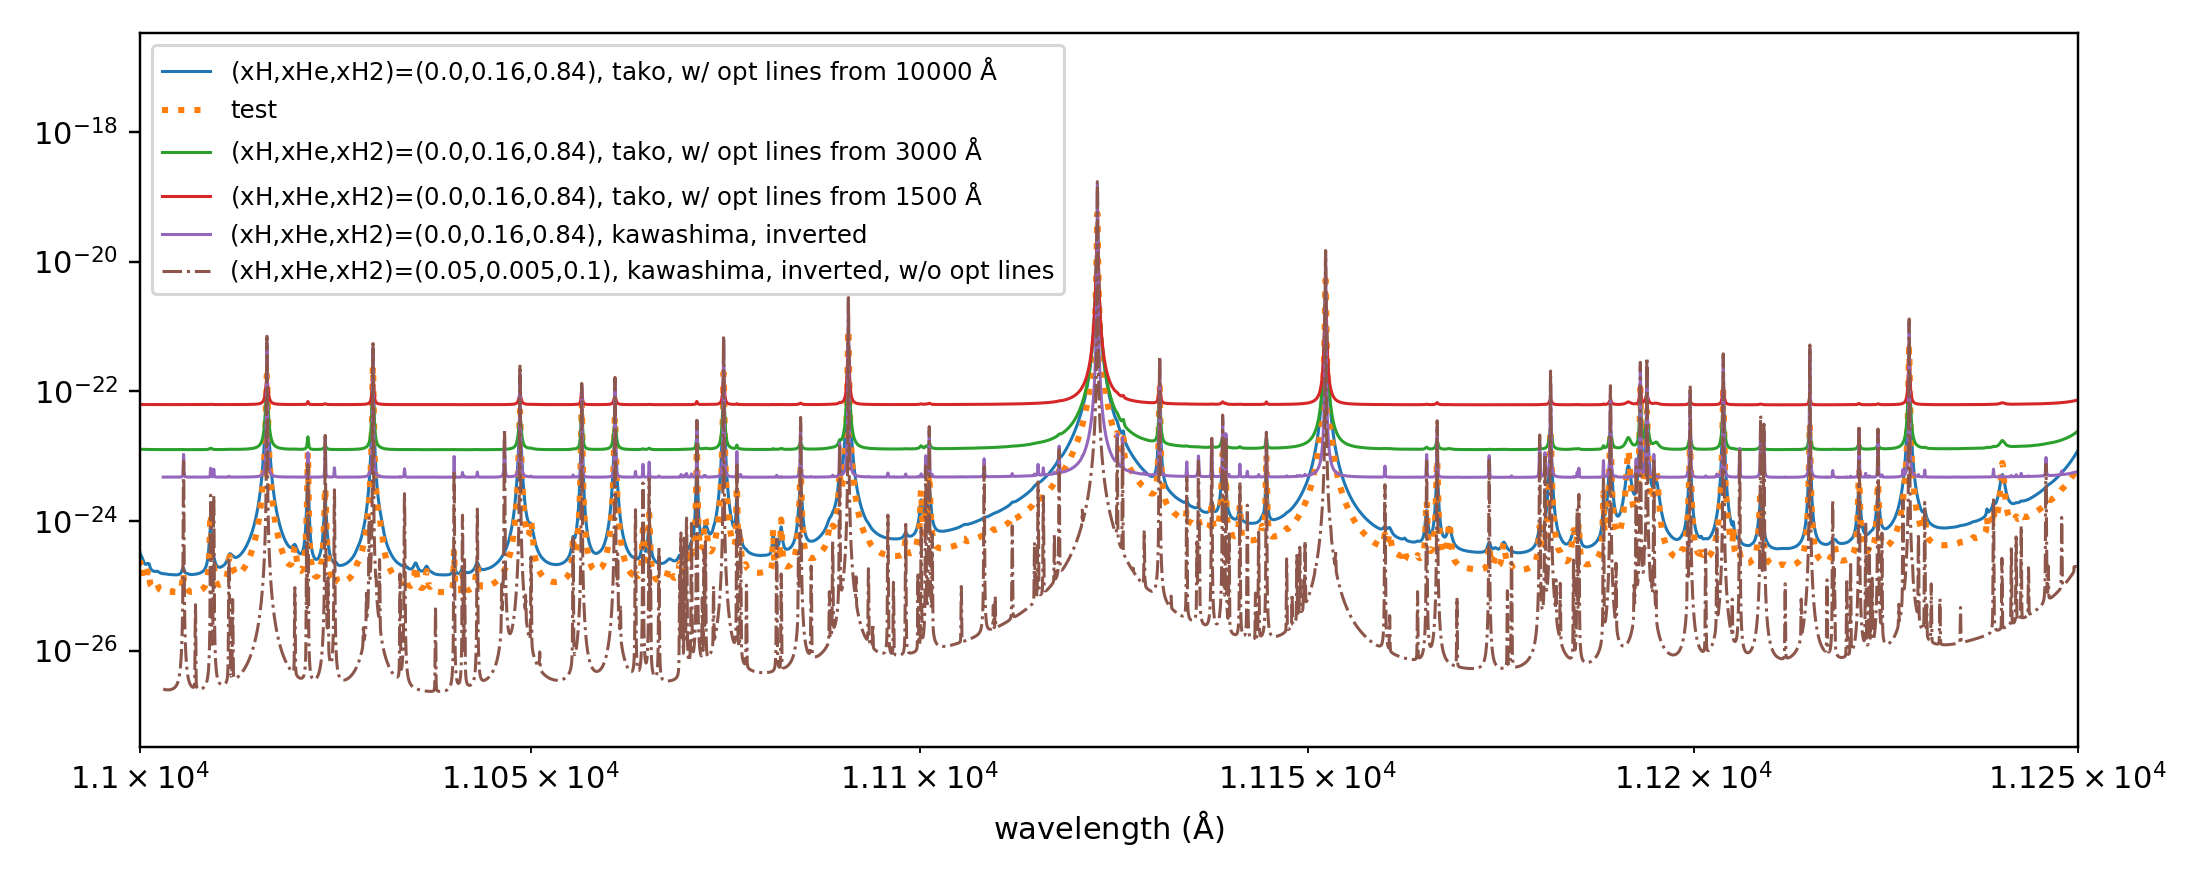

In [87]:
fig, ax1=plt.subplots(figsize=(10,4), tight_layout=True) #15, 5

#ax1.plot(wav_excerpt*1.e8, xs_excerpt, lw=1, label='tako')
#ax1.plot(wav_excerpt*1.e8, xs_p_interp, ':', lw=1, label='petitRADTRANS')

#ax1.plot(wav_excerpt*1.e8, xs_ish_excerpt, lw=1, label='(xH,xHe,xH2)=(0.05,0.005,0.1), tako')
#ax1.plot(wav_excerpt*1.e8, xs_sol_excerpt, lw=1, label='(xH,xHe,xH2)=(0.0,0.16,0.84), tako')
#ax1.plot(wav_excerpt*1.e8, xs_excerpt, lw=1, label='(xH,xHe,xH2)=(0.0,0.16,0.84), tako, Unsöld')
#ax1.plot(wav_excerpt*1.e8, xs_wopt_excerpt, lw=1, label='(xH,xHe,xH2)=(0.0,0.16,0.84), tako, w/ opt lines')
#ax1.plot(wav_excerpt*1.e8, xs_ghalf_excerpt, lw=1, label='(xH,xHe,xH2)=(0.0,0.16,0.84), tako, half-gamma')


ax1.plot(wav_4204004ex*1.e8, xs_wopt10000ex, lw=1, label='(xH,xHe,xH2)=(0.0,0.16,0.84), tako, w/ opt lines from 10000 $\mathrm{\AA}$')
ax1.plot(wav*1.e8, xs, lw=2, linestyle=':', label='test') #, label='(xH,xHe,xH2)=(0.05,0.005,0.1),')
ax1.plot(wav_4204595ex*1.e8, xs_wopt3000ex, lw=1, label='(xH,xHe,xH2)=(0.0,0.16,0.84), tako, w/ opt lines from 3000 $\mathrm{\AA}$')
ax1.plot(wav_4204596ex*1.e8, xs_woptex, lw=1, label='(xH,xHe,xH2)=(0.0,0.16,0.84), tako, w/ opt lines from 1500 $\mathrm{\AA}$')

#ax1.plot(wav_yk, ko_ish_inverted[:,1], lw=1, label='(xH,xHe,xH2)=(0.05,0.005,0.1), inverted')
ax1.plot(wav_yk, ko_sol_inverted[:,1], lw=1, label='(xH,xHe,xH2)=(0.0,0.16,0.84), kawashima, inverted')
ax1.plot(wav_yk, ko_ish_wo_VIS[:,1], '-.', lw=1, label='(xH,xHe,xH2)=(0.05,0.005,0.1), kawashima, inverted, w/o opt lines')

ax1.set_xlim(xrg)
#ax1.set_ylim(yrg)

ax1.set_xscale("log")
ax1.set_yscale("log")
ax1.set_xlabel("wavelength ($\mathrm{\AA}$)")
ax1.legend(fontsize=8)

#plt.subplots_adjust(hspace=.05)
#plt.savefig(path_fig+'comp_diff_Fe'+'_optical_from_different_wav'+'.pdf') #out_suffix
plt.show()

In [70]:
plt.savefig(path_fig+'comp_diff_Fe'+'_optical_from_different_wav_zoomin_'+'.pdf') #out_suffix

#### 川島さんが計算してくださった範囲に合わせて比較

In [128]:
import copy
#xsyobi2=copy.deepcopy(xs)

<IPython.core.display.Javascript object>


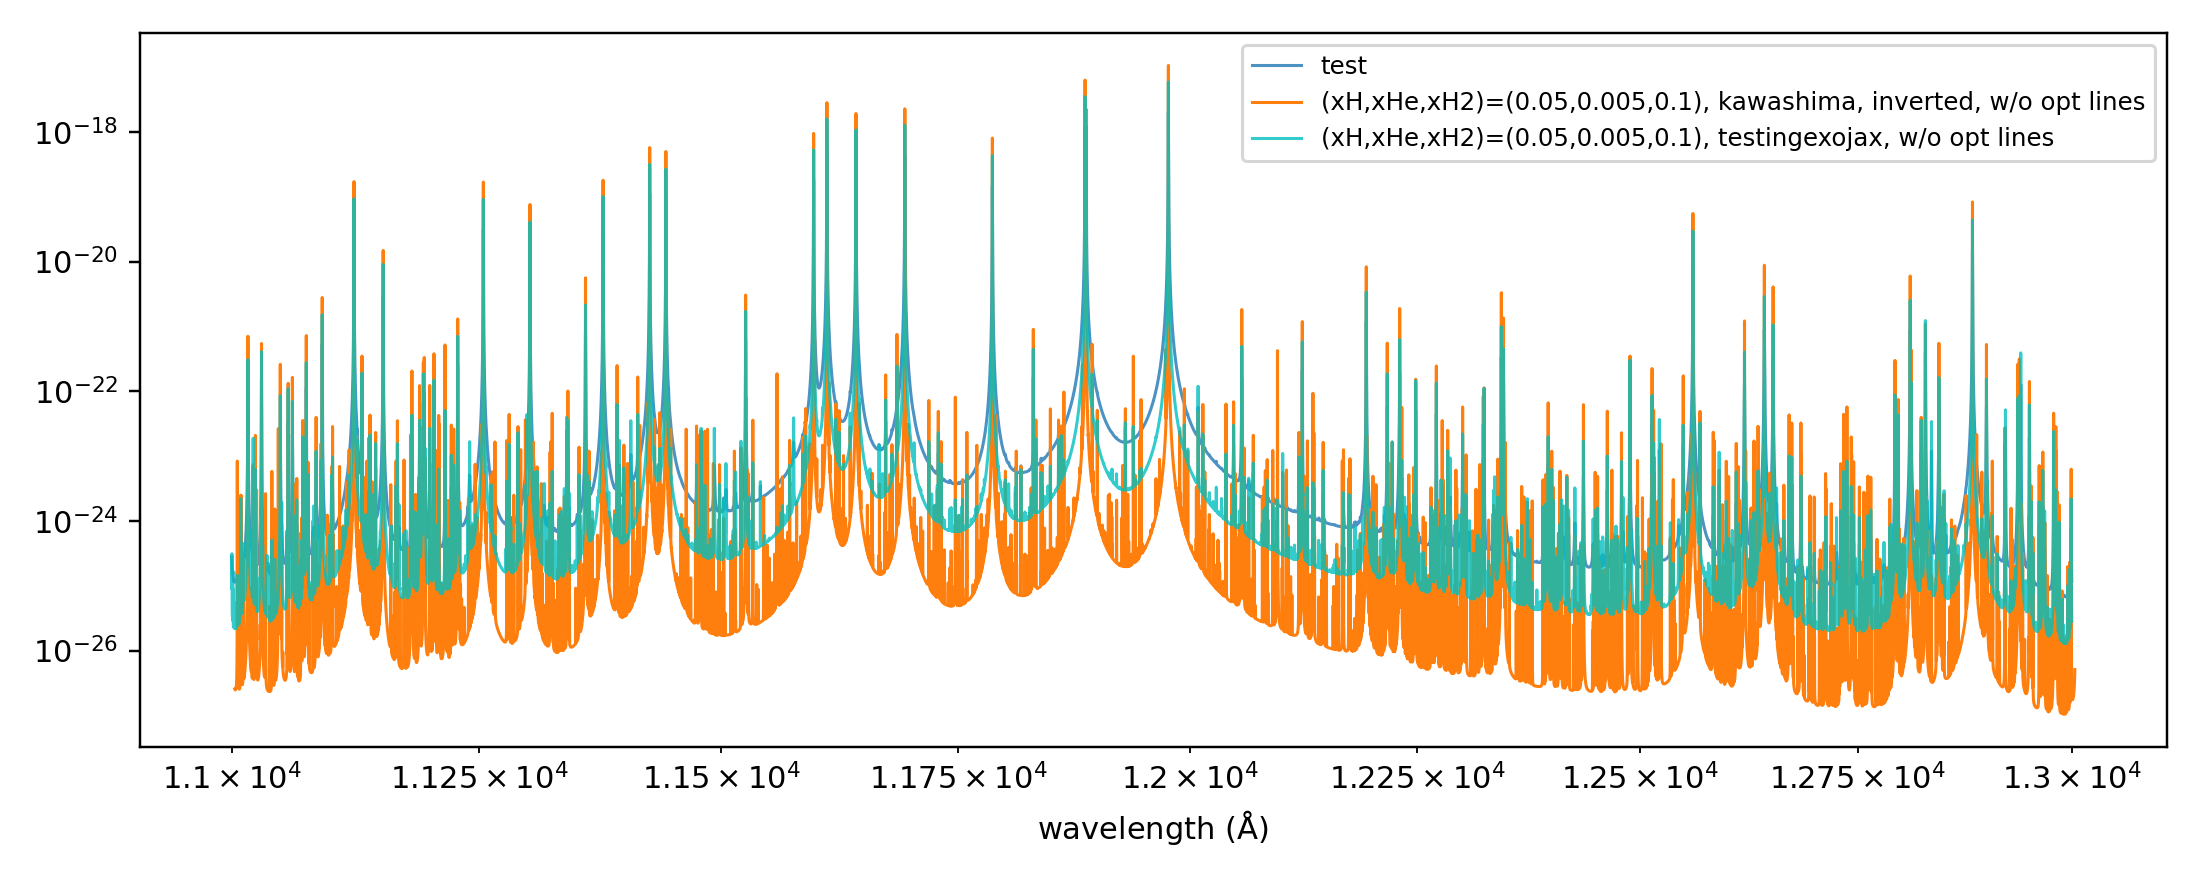

In [174]:
fig, ax1=plt.subplots(figsize=(10,4), tight_layout=True) #15, 5

ax1.plot(wav*1.e8, xs, lw=1, linestyle='-', alpha=0.8, label='test')#, 'r'

#ax1.plot(wav_yk, ko_sol_inverted[:,1], lw=1, label='(xH,xHe,xH2)=(0.0,0.16,0.84), kawashima, inverted') #, alpha=0.0)#
ax1.plot(wav_yk, ko_ish_wo_VIS[:,1], '-', color='C1', lw=1, label='(xH,xHe,xH2)=(0.05,0.005,0.1), kawashima, inverted, w/o opt lines')
#ax1.plot(wav*1.e8, xsyobi, 'k', lw=1, linestyle='-', alpha=0.8, label='(xH,xHe,xH2)=(0.0,0.16,0.84), testingexojax, w/o opt lines')
ax1.plot(wav*1.e8, xs_takofrac, 'c', lw=1, linestyle='-', alpha=0.8, label='(xH,xHe,xH2)=(0.05,0.005,0.1), testingexojax, w/o opt lines')
#ax1.plot(wav*1.e8, xsyobi2, 'slateblue', lw=1, linestyle='-', alpha=0.8, label='(xH,xHe,xH2)=(0.0,0.0016,0.0084), testingexojax, w/o opt lines')

ax1.set_xscale("log")
ax1.set_yscale("log")
ax1.set_xlabel("wavelength ($\mathrm{\AA}$)")
ax1.legend(fontsize=8)

#plt.subplots_adjust(hspace=.05)
#plt.savefig(path_fig+'comp_diff_Fe'+'_optical_from_different_wav_rep'+'.pdf') #out_suffix
plt.show()

In [165]:
plt.savefig(path_fig+'comp_diff_Fe'+'_optical_from_different_wav_rep2'+'.pdf') #out_suffix


In [144]:
plt.savefig(path_fig+'comp_diff_Fe'+'_KawashimaRange'+'.pdf') #out_suffix

# 全波長のvisual check
可視側がどうなってるか  

In [ ]:
fig, ax1=plt.subplots(figsize=(10,4), tight_layout=True) #15, 5

ax1.plot(wav_4204596*1.e8, xs_wopt, lw=1, label='(xH,xHe,xH2)=(0.0,0.16,0.84), tako, w/ opt lines')
#ax1.plot(wav_excerpt*1.e8, xs_ghalf_excerpt, lw=1, label='(xH,xHe,xH2)=(0.0,0.16,0.84), tako, half-gamma')
#ax1.plot(wav_opt*1.e8, xs_opt, lw=1, label='(xH,xHe,xH2)=(0.0,0.16,0.84), tako, only opt lines')

ax1.plot(wav_yk, ko_sol_inverted[:,1], lw=1, label='(xH,xHe,xH2)=(0.0,0.16,0.84), inverted')
ax1.plot(wav_yk, ko_ish_wo_VIS[:,1], '-.', lw=1, label='(xH,xHe,xH2)=(0.05,0.005,0.1), inverted, w/o opt lines')

ax1.set_xlim(xrg)
#ax1.set_ylim(yrg)

ax1.set_xscale("log")
ax1.set_yscale("log")
ax1.set_xlabel("wavelength ($\AA$)")
ax1.legend()

#plt.subplots_adjust(hspace=.05)
plt.savefig(path_fig+'wopt_whole_wavelength_check_long.pdf')
#plt.show()

<IPython.core.display.Javascript object>